# Case Study Details

## Problem Statement

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.


A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 


In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.


They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

Which variables are significant in predicting the demand for shared bikes.
How well those variables describe the bike demands
Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

## Business Goal:

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

# Understanding the Data

day.csv have the following fields:
	`
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load the data

In [3]:
bikes = pd.read_csv("input/day.csv",encoding='ISO-8859-1')

In [4]:
bikes.shape

(730, 16)

In [5]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
instant       730 non-null int64
dteday        730 non-null object
season        730 non-null int64
yr            730 non-null int64
mnth          730 non-null int64
holiday       730 non-null int64
weekday       730 non-null int64
workingday    730 non-null int64
weathersit    730 non-null int64
temp          730 non-null float64
atemp         730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
casual        730 non-null int64
registered    730 non-null int64
cnt           730 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.3+ KB


In [6]:
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# Create variables - continuous, categorical & target

In [7]:
DEPENDENT_VARIABLE = 'cnt'
CONTINUOUS_VARIABLES = ['temp','atemp','hum','windspeed']
CATEGORICAL_VARIABLES = ['season','mnth','weekday','weathersit']
BINARY_CATEGORICAL_VARIABLES = ['yr','holiday','workingday']

# Check Missing

In [8]:
# Print missing percentage of only columns with missing values
missing_columns = bikes.columns[bikes.isnull().any()]
missing_count = bikes[missing_columns].isnull().sum() 
pd.concat({
                "Missing": missing_count, 
                "Missing %": missing_count/len(bikes.index)*100
               } , 
               axis = 1).sort_values(by = 'Missing', ascending = False)

,Missing,Missing %


<font color='green'>NOTE: There are NO missing values in the dataset </font>

# Datatype conversions

## Convert season to categorical variable

In [9]:
bikes['season'] = bikes['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

## Convert month to categorical variable

In [10]:

bikes['mnth'] = bikes['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

## Convert weekday to categorical variable
01-01-2018 is Monday and marked as 6

In [11]:
bikes['weekday'] = bikes['weekday'].map({0:'Tue', 1:'Wed', 2:'Thu', 3:'Fri', 4:'Sat', 5:'Sun', 6:'Mon'})

## Convert weathersit to categorical variable

In [12]:
bikes['weathersit'] = bikes['weathersit'].map({1:'Clear', 2:'Misty', 3:'LightRain', 4:'HeavyRain'})

# Drop unused variables

Some of the variables are not required for the analysis and can be removed: <br>
instant - unique identifier <br>
dteday - date information is already split to different columns <br>
casual & registered - only overall cnt is required in this problem. Casual and registered users information can be dropped.

In [13]:
bikes.shape

(730, 16)

In [14]:
bikes.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [15]:
bikes.shape

(730, 12)

# EDA

## Target Distribution

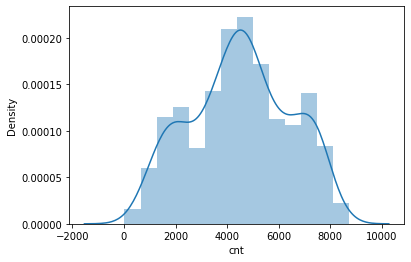

In [16]:
sns.distplot(bikes[DEPENDENT_VARIABLE])

## Categorical variables

### Categorical variables - Univariate Analysis & Segmented Univariate Analysis


------------------ Variable: season ------------------- 



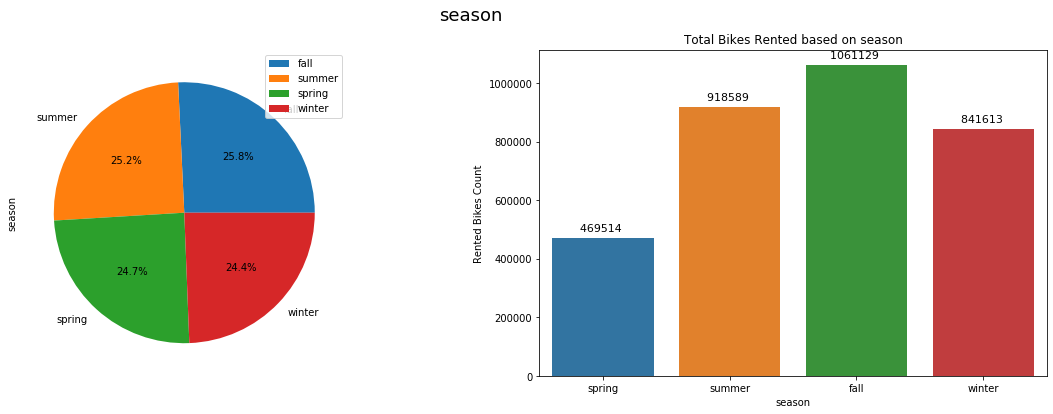


------------------ Variable: mnth ------------------- 



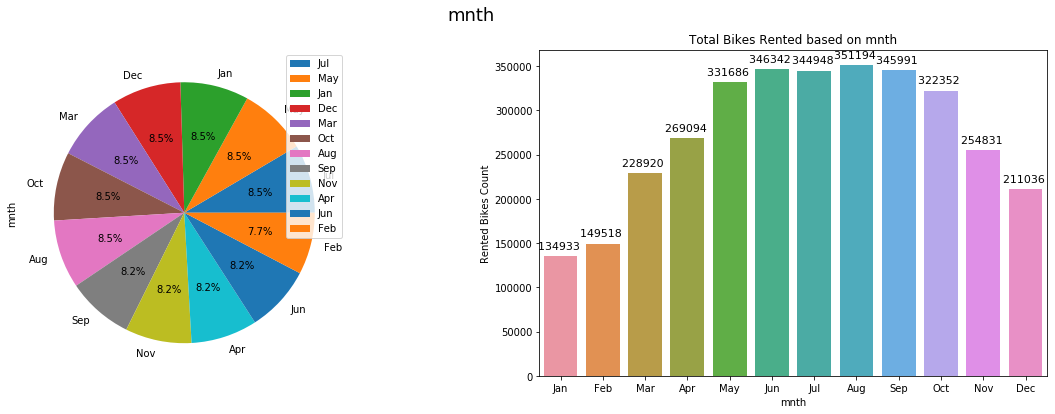


------------------ Variable: weekday ------------------- 



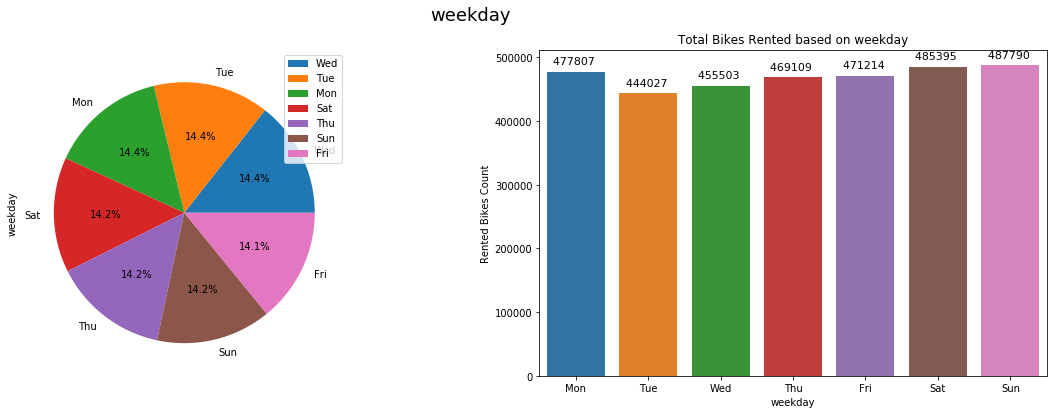


------------------ Variable: weathersit ------------------- 



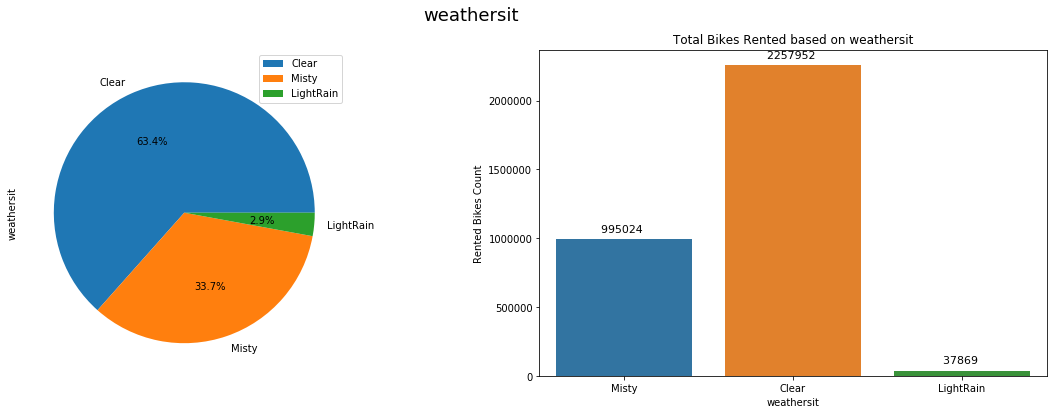


------------------ Variable: yr ------------------- 



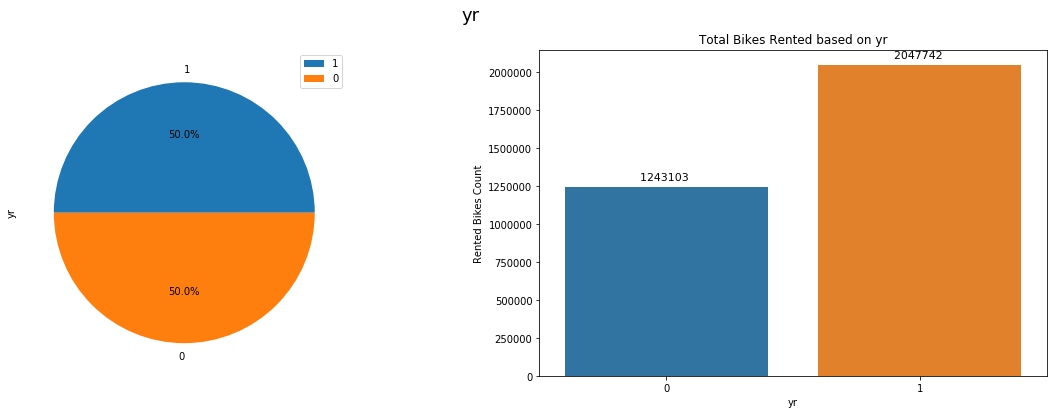


------------------ Variable: holiday ------------------- 



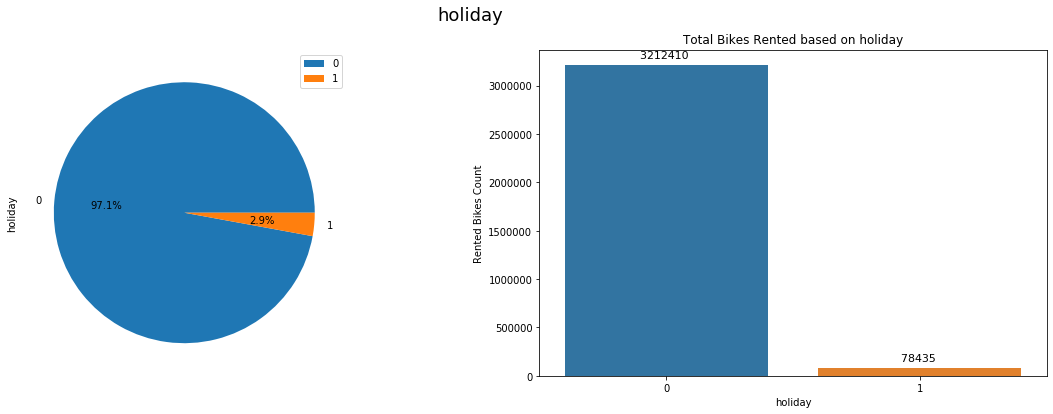


------------------ Variable: workingday ------------------- 



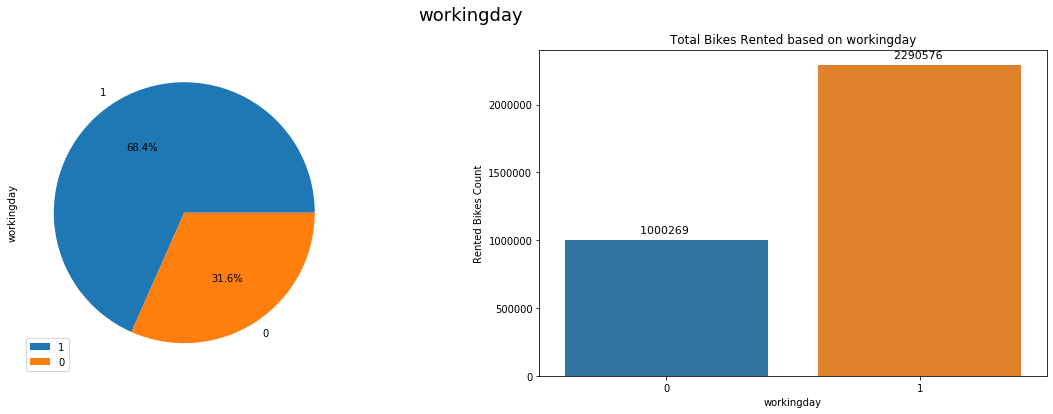

In [17]:
# For each categorical variable, plot
# 1. Percentage distribution of each category - Univariate Analysis
# 2. Bar chart to show the total bikes rented in that season - Segmented Univariate Analysis 


for col in CATEGORICAL_VARIABLES + BINARY_CATEGORICAL_VARIABLES:
    
    print(f'\n------------------ Variable: {col} ------------------- \n')
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(col, fontsize=18)
    # Chart 1
    bikes[col].value_counts().plot.pie(ax=ax[0], autopct="%1.1f%%")
    ax[0].legend()
    # Chart 2
    group_df = pd.DataFrame(bikes.groupby([col],sort=False)['cnt'].sum())
    sns.barplot(x=group_df.index, y=group_df['cnt'], ax=ax[1])


    ax[1].set(xlabel=col, ylabel='Rented Bikes Count',title = f'Total Bikes Rented based on {col}') 

    #annotate axis = seaborn axis
    for p in ax[1].patches:
                 ax[1].annotate("%.0f " % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11,  xytext=(0, 10),
                     textcoords='offset points')
        
    
    plt.yticks(rotation = 0)
    plt.show()

<font color='green'>
<b> Observations:</b> 
<li>Season: More bikes are rented out in fall followed by summer, winter and spring </li>
<li>Months: Months May to October have more demand as compared to the other months</li>
<li>Weekday: Demand is more or less uniform on all days of the week with a slightly more demand over the weekend</li>
<li>Weather Situation: As expected, clear weather draws in more bike rentals that is shown in the data as well</li>
<li>Year: 2019 has more bike rentals as compared to 2018</li>
</font>

###  Per day average - bar chart plots 

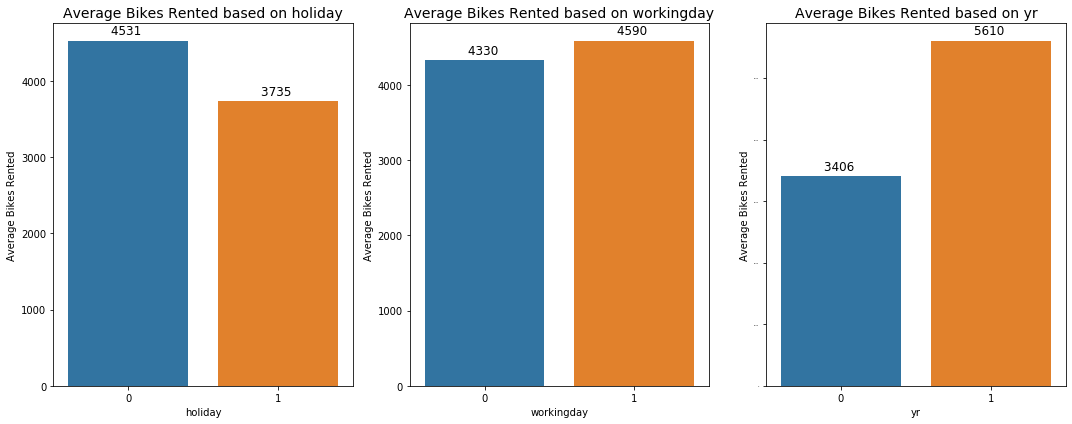

In [18]:
# For the three columns - yr, holiday, workingday, plot the average bikes rented per day

fig, ax = plt.subplots(1,3, figsize=(15, 6))


def plot_average_bar_chart(col, plot_ax):
    group_df = pd.DataFrame(bikes.groupby([col],sort=False)['cnt'].sum()/bikes.groupby([col],sort=False)['cnt'].count())
    sns.barplot(x=group_df.index, y=group_df['cnt'],label='small', ax=ax[plot_ax])


    ax[plot_ax].set_xlabel(f'{col}',fontsize=10)
    ax[plot_ax].set_ylabel(f'Average Bikes Rented',fontsize=10)
    ax[plot_ax].set_title(f'Average Bikes Rented based on {col}',fontsize=14)
    
    plt.yticks(rotation = 0,fontsize=2)                                                           
    plt.tight_layout()         
    
    #annotate axis = seaborn axis
    for p in ax[plot_ax].patches:
                 ax[plot_ax].annotate("%.0f " % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12,  xytext=(0, 10),
                     textcoords='offset points')


plot_average_bar_chart(col = 'holiday', plot_ax = 0)
plot_average_bar_chart(col = 'workingday', plot_ax = 1)
plot_average_bar_chart(col = 'yr', plot_ax = 2)

<font color='green'>
<b> Observations:</b> 
<li>On an average, more no. of bikes are rented per day on holidays</li>
<li>No. of bikes rented on working days is marginally more than the no. of bikes rented per day on weekends or holidays</li>
<li>Average bikes rented per day in 2019 is more as compared to 2018</li>
</font>

###  Analysing the bike rentals for each year

In [19]:
def plot_grouped_chart_against_year(col,palette = 'magma',rotation=0, title = None): 
    
    f = plt.subplots(figsize=(8,6))
    ax = sns.barplot(x=bikes[col],y=bikes['cnt'],hue=bikes['yr'],palette=palette) 
    title = f'Bikes rental demand for each {col} in 2018 & 2019' if (title is None) else title
    ax.set(xlabel=col, ylabel='Bikes Rented', title = title)
    plt.xticks(rotation = rotation)
    #annotate axis = seaborn axis
    for p in ax.patches:
                 ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11,  xytext=(0, 10),
                     textcoords='offset points')
    
    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, ['2018','2019'], title="Year")
    #plt.legend(['2018','2019'], loc="best", title = 'Year')
    plt.show()


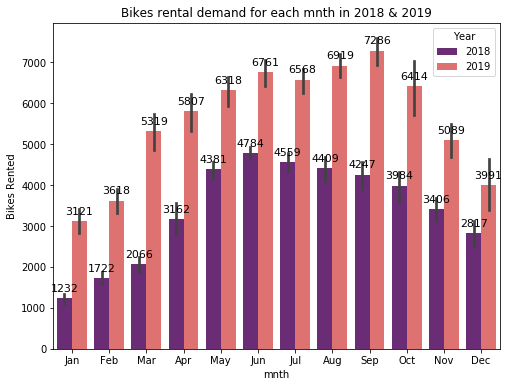

In [20]:
plot_grouped_chart_against_year('mnth')

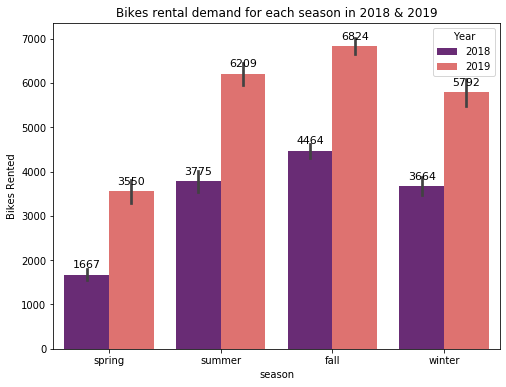

In [21]:
plot_grouped_chart_against_year('season')

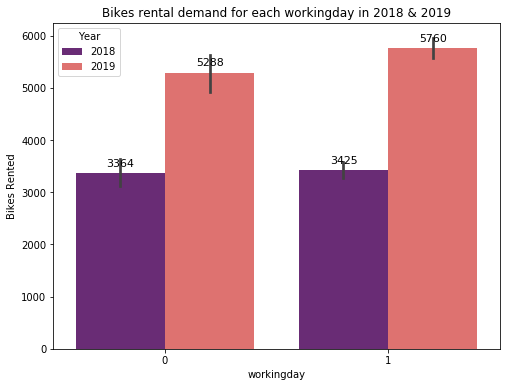

In [22]:
plot_grouped_chart_against_year('workingday')

<font color='green'>
<b> Observations:</b> 
<li>Comparing the bike rentals in 2018 & 2019, it is clear that there has been more bike rentals in 2019 as compared to 2018 across all the months and seasons</li>
</font>

## Continuous Variables - Univariate Analysis


------------------ Variable: temp ------------------- 



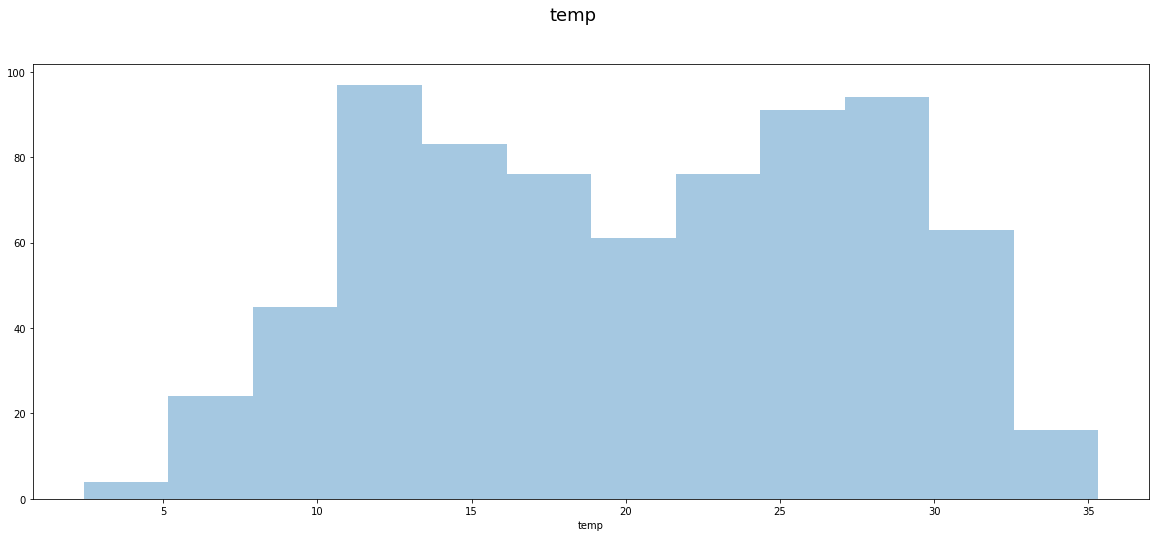


------------------ Variable: atemp ------------------- 



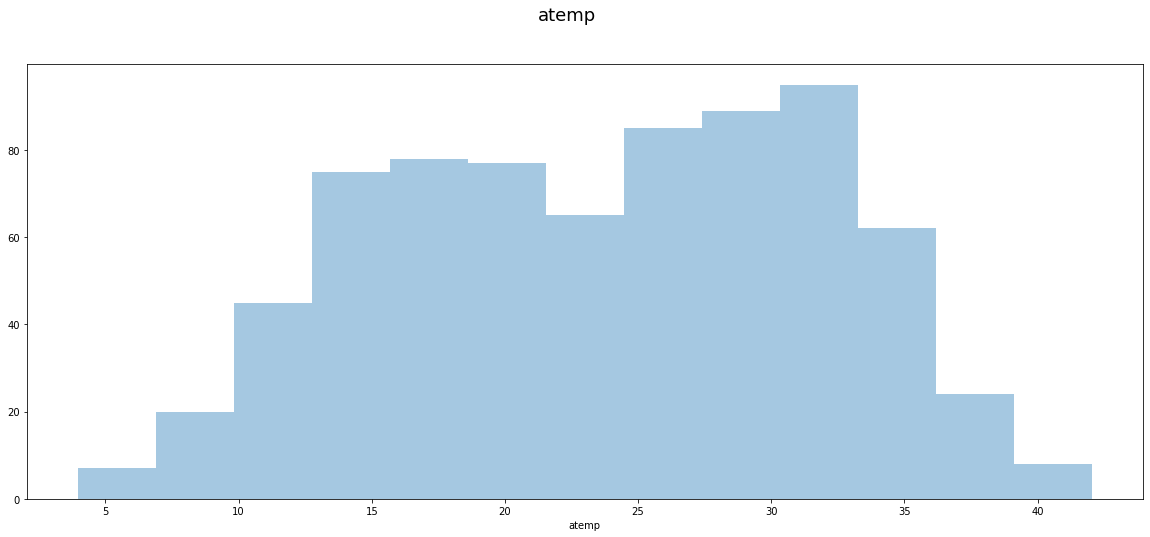


------------------ Variable: hum ------------------- 



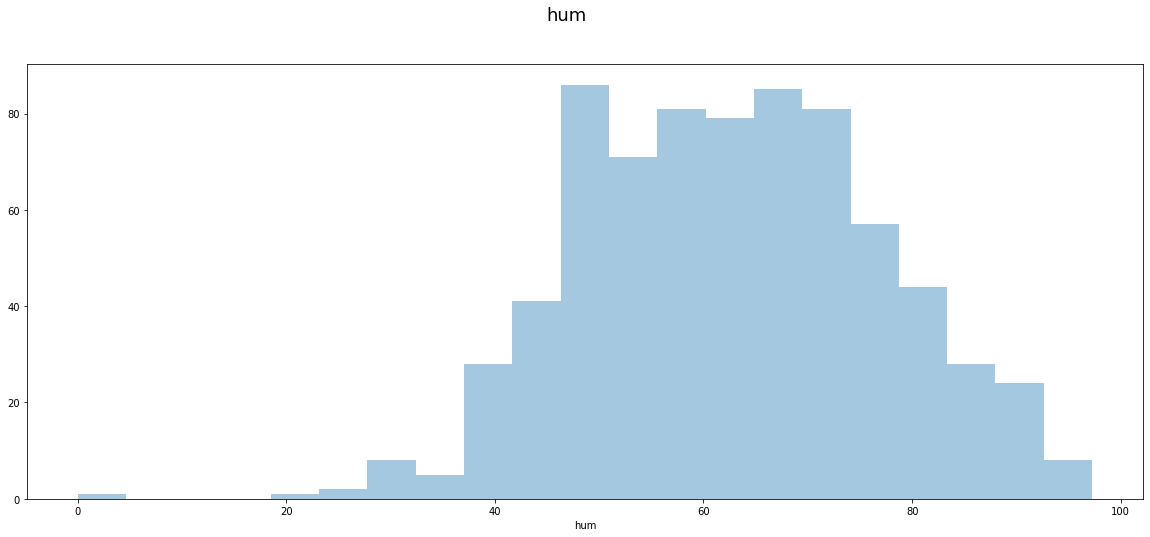


------------------ Variable: windspeed ------------------- 



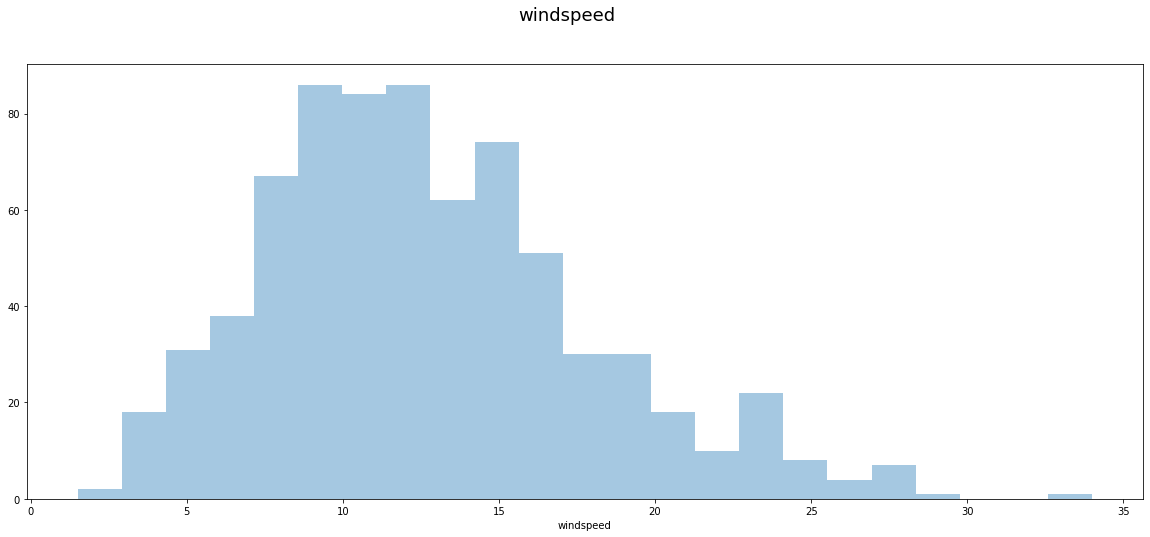

In [23]:
# Check the distribution of each continuous variable
for col in CONTINUOUS_VARIABLES:
    print(f'\n------------------ Variable: {col} ------------------- \n')
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    fig.suptitle(col, fontsize=18)
    sns.distplot(bikes[col], kde=False)
    plt.show()

## Bivariate Analysis - Pair plots & heat map

### Numeric Variables - Heat Map

In [24]:
corrdf = bikes[CONTINUOUS_VARIABLES+[DEPENDENT_VARIABLE]]

In [25]:
# Heat Map
corr = corrdf.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,temp,atemp,hum,windspeed,cnt
temp,1,1,0.1,-0.2,0.6
atemp,1,1,0.1,-0.2,0.6
hum,0.1,0.1,1,-0.2,-0.1
windspeed,-0.2,-0.2,-0.2,1,-0.2
cnt,0.6,0.6,-0.1,-0.2,1


### Numeric Variables - Pair Plot

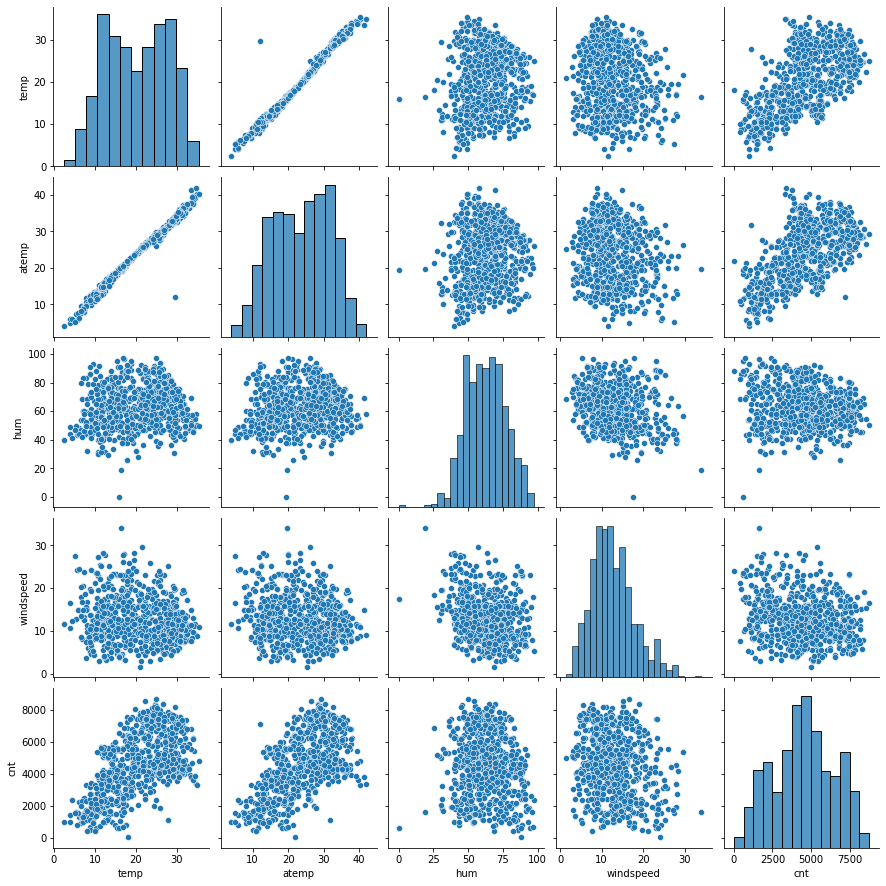

In [26]:
# Pair Plot
sns.pairplot(corrdf)

<font color='green'>
<b> Observation:</b> 
<li>As seen in the heat map, there is multicollinearity in the data.</li>
<li>temp & atemp variables are perfectly correlated. One of them can be removed for the final model</li>
<li>temp (and atemp) is positively correlated with the bikes rented count (target) </li>
<li> There is not much of correlation between the windspeed/humidity and bikes rented count. They may not be significant variables to predict the bike rental count.</li>
</font>

# Create Dummy Variables

In [27]:
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [28]:
dummy_cols = ['season','mnth','weekday','weathersit']

In [29]:
dummies = pd.get_dummies(bikes[dummy_cols],drop_first=True)
bikes = pd.concat([bikes,dummies],axis=1)
bikes.drop(dummy_cols,axis=1,inplace=True)
bikes.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_LightRain,weathersit_Misty
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
bikes.shape

(730, 30)

In [31]:
# Check the correlation between variables after creating the dummy variables.
bikes.corr().style.background_gradient(cmap='coolwarm').set_precision(1)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_LightRain,weathersit_Misty
yr,1,0.008,-0.003,0.05,0.05,-0.1,-0.01,0.6,-2e-17,-5e-18,2e-17,9e-18,1e-17,1e-19,-1e-19,-1e-19,-5e-18,-1e-19,-1e-19,-7e-18,9e-18,-9e-18,-0.004,2e-19,2e-19,7e-19,0.004,0.004,-0.07,-0.006
holiday,0.008,1,-0.3,-0.03,-0.03,-0.02,0.006,-0.07,0.03,-0.02,0.02,-0.05,0.006,0.01,0.04,0.006,-0.05,-0.05,0.006,0.07,0.006,0.008,-0.07,-0.02,-0.02,-0.05,-0.07,0.3,-0.03,-0.02
workingday,-0.003,-0.3,1,0.05,0.05,0.02,-0.02,0.06,-0.03,0.02,-0.005,0.04,-0.01,-0.003,-0.03,-0.01,0.02,0.03,0.007,-0.01,-0.004,-0.01,-0.6,0.3,0.3,0.3,-0.6,0.2,0.03,0.05
temp,0.05,-0.03,0.05,1,1,0.1,-0.2,0.6,-0.6,0.2,-0.2,0.4,-0.3,-0.3,-0.4,0.4,0.3,-0.2,0.2,-0.2,-0.02,0.2,-0.03,0.02,-5e-06,0.02,-0.03,-0.005,-0.06,-0.1
atemp,0.05,-0.03,0.05,1,1,0.1,-0.2,0.6,-0.6,0.2,-0.2,0.3,-0.3,-0.3,-0.4,0.4,0.3,-0.2,0.2,-0.2,-0.005,0.2,-0.03,0.02,-0.009,0.02,-0.02,9e-05,-0.06,-0.09
hum,-0.1,-0.02,0.02,0.1,0.1,1,-0.2,-0.1,-0.2,-0.003,0.2,0.02,0.08,-0.1,-0.09,-0.06,-0.1,-0.08,0.1,-0.006,0.1,0.2,-0.02,-0.05,-0.04,0.04,2e-05,0.03,0.3,0.5
windspeed,-0.01,0.006,-0.02,-0.2,-0.2,-0.2,1,-0.2,0.2,0.1,-0.1,-0.07,-0.05,0.1,0.06,-0.1,-0.02,0.1,-0.03,-0.03,-0.06,-0.09,0.03,0.006,-0.02,0.007,-0.01,0.001,0.1,-0.04
cnt,0.6,-0.07,0.06,0.6,0.6,-0.1,-0.2,1,-0.6,0.1,0.06,0.2,-0.2,-0.3,-0.4,0.2,0.2,-0.1,0.1,-0.04,0.1,0.2,0.009,0.03,0.04,0.0006,-0.06,-0.04,-0.2,-0.2
season_spring,-2e-17,0.03,-0.03,-0.6,-0.6,-0.2,0.2,-0.6,1,-0.3,-0.3,-0.2,0.08,0.5,0.5,-0.2,-0.2,0.3,-0.2,-0.2,-0.2,-0.2,0.01,-0.006,0.003,-0.006,0.01,0.001,-0.02,0.03
season_summer,-5e-18,-0.02,0.02,0.2,0.2,-0.003,0.1,0.1,-0.3,1,-0.3,-0.2,-0.2,-0.2,-0.2,-0.2,0.3,0.07,0.5,-0.2,-0.2,-0.2,-0.004,-0.002,-0.002,-0.002,-0.004,0.005,-0.04,0.04


# Train-Test Split

In [32]:
X = bikes.drop([DEPENDENT_VARIABLE],axis=1)
y = bikes[DEPENDENT_VARIABLE]

In [33]:
# 70% of data used as train data and the remaining 30% as test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=100)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(511, 29)
(219, 29)
(511,)
(219,)


In [35]:
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'weathersit_LightRain', 'weathersit_Misty'],
      dtype='object')

# Check & Treat outliers - train data

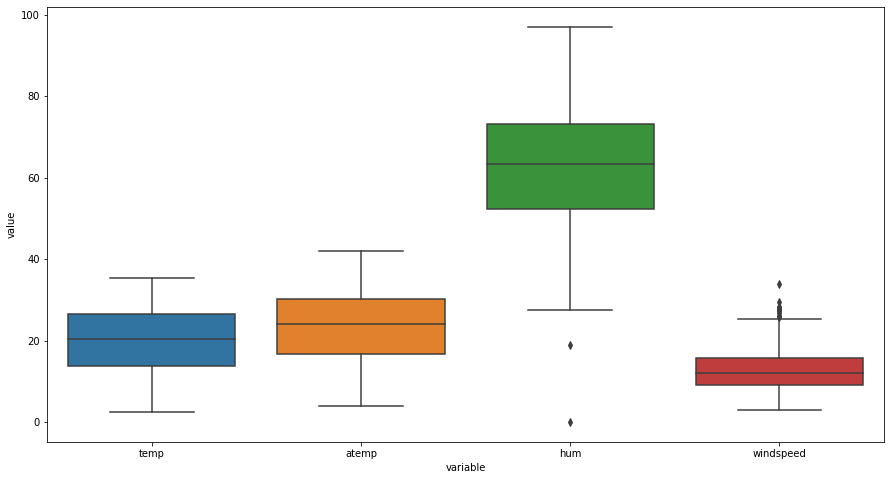

In [36]:
# bikes[CONTINUOUS_VARIABLES].boxplot()
plt.figure(figsize=(15,8))
sns.boxplot(x='variable',y='value',data=pd.melt(X_train[CONTINUOUS_VARIABLES]))

<font color='green'>
<b> Observation:</b> 
<li>Outliers in windspeed are mostly during clear weather and it could be due to incorrect data.</li>
<li>We can cap these values so that they dont impact the model.</li>
</font>

In [37]:
# Treat high windspeed outliers in train data
q_windspeed_cap = X_train['windspeed'].quantile(0.95)
X_train.loc[X_train['windspeed'] > q_windspeed_cap,'windspeed']=q_windspeed_cap

# Treat low humidity outliers in train data
q_hum_floor = X_train['hum'].quantile(0.01)
X_train.loc[X_train['hum'] < q_hum_floor,'hum'] = q_hum_floor

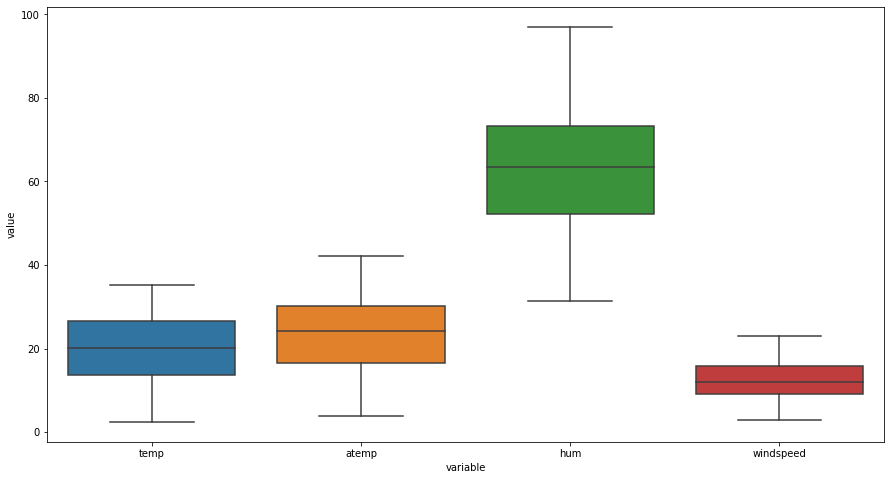

In [38]:
# Check outliers again to confirm that they are treated
plt.figure(figsize=(15,8))
sns.boxplot(x='variable',y='value',data=pd.melt(X_train[CONTINUOUS_VARIABLES]))

# Feature Scaling

In [39]:
scaler = MinMaxScaler()
scale_cols = ['temp','atemp','hum','windspeed']
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])

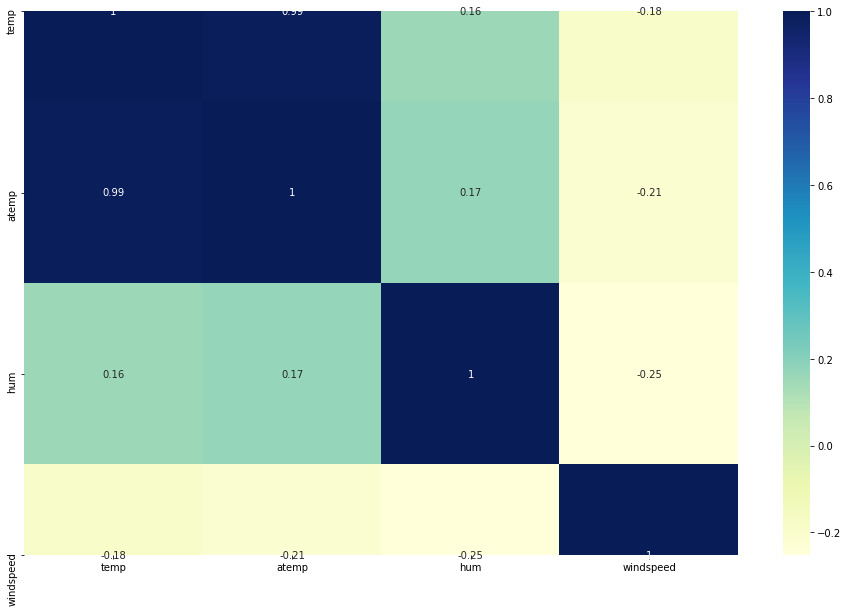

In [40]:
# Check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(X_train[CONTINUOUS_VARIABLES].corr(), annot = True, cmap="YlGnBu")
plt.show()

# Utility Methods - build stats model, print VIF

In [41]:
# Utility method to fit a linear model using statsmodels and print the summary
def fit_stats_model(X_data,y_data):
    X_data = sm.add_constant(X_data)
    lm_model = sm.OLS(y_data,X_data).fit()
    print(lm_model.summary())  
    return lm_model

In [42]:
# Utility method to find the VIF of all the variables in the dataset 
def print_vif(X_data):
    vif = pd.DataFrame({'Features':X_data.columns})
    #vif['Features'] = X_data.columns
    vif['VIF'] = [round(variance_inflation_factor(X_data.values, i), 2) for i in range(X_data.shape[1])]
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)
    

# MODEL 1 - Linear Model with all features

In [43]:
X_train_lm = X_train.copy()
fit_stats_model(X_train_lm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     98.62
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          7.79e-180
Time:                        10:41:53   Log-Likelihood:                -4109.5
No. Observations:                 511   AIC:                             8277.
Df Residuals:                     482   BIC:                             8400.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1783.0923 

<font color = 'green'>
Observations - running model with all features: <br>
    * <b>R-squared & adjusted R-squared:</b> The R-squared & adjusted R-squared values are good. Almost ~85% variance in the data can be explained by the model.<br>
    * <b>Model Significance [prob(F-stat)]:</b> The prob(F-stat) score is good ( < 0.05), which shows that the overall model is good<br>
    * <b>Individual p-values:</b> Looking at the p-values of individual variables, there are many variable with p-value > 0.05 which indicates that there are insignificant variables in the model that can be removed.<br>
</font>

In [44]:
# VIF
print_vif(X_train_lm)

,Features,VIF
2,workingday,77.89
3,temp,66.80
4,atemp,56.10
21,weekday_Mon,17.72
25,weekday_Tue,16.27
7,season_spring,10.78
9,season_winter,9.52
8,season_summer,8.30
18,mnth_Nov,6.79
19,mnth_Oct,6.57


<font color=green>
There are many variables with a high VIF  (> 5). This indicates that these variables are multicollinear and can be dropped.<br>
</font>

# MODEL 2 - RFE - get 15 most important features

## Get the top 15 features using RFE

In [45]:
# Part of sklearn package. Requires a model object. 
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)    
rfe = rfe.fit(X_train, y_train)

In [46]:
rfe_df = pd.DataFrame(zip(X_train.columns,rfe.support_,rfe.ranking_),columns = ['Feature','Selected','Ranking'])
rfe_df.sort_values(by=['Ranking'])

,Feature,Selected,Ranking
0,yr,True,1
21,weekday_Mon,True,1
20,mnth_Sep,True,1
27,weathersit_LightRain,True,1
9,season_winter,True,1
8,season_summer,True,1
7,season_spring,True,1
14,mnth_Jul,True,1
5,hum,True,1
1,holiday,True,1


## Build model with the top 15 variables from RFE

In [47]:
rfe_cols = X_train.columns[rfe.support_]
rfe_cols

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Jul',
       'mnth_Sep', 'weekday_Mon', 'weathersit_LightRain', 'weathersit_Misty'],
      dtype='object')

In [48]:
X_train_lm = X_train[rfe_cols]
fit_stats_model(X_train_lm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.8
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.06e-189
Time:                        10:41:54   Log-Likelihood:                -4119.2
No. Observations:                 511   AIC:                             8270.
Df Residuals:                     495   BIC:                             8338.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1660.2832 

<font color = 'green'>
<b>Observations - running model with all features: </b><br>
    * <b>R-squared & adjusted R-squared:</b> The R-squared & adjusted R-squared values are good. Almost ~85% variance in the data can be explained by the model.<br>
    * <b>Model Significance [prob(F-stat)]:</b> The prob(F-stat) score is good ( < 0.05), which shows that the overall model is good<br>
    * <b>Individual p-values:</b> All the features have a p-value less than 0.05 which implies that all of them are significant<br>
</font>

In [49]:
print_vif(X_train_lm)

,Features,VIF
3,temp,373.56
4,atemp,369.60
5,hum,11.96
6,windspeed,5.52
2,workingday,5.22
7,season_spring,3.22
9,season_winter,2.82
8,season_summer,2.69
14,weathersit_Misty,2.48
0,yr,2.10


<font color=green>
VIF of some of the variables is high (> 5). This indicates that these variables are multicollinear and can be dropped.<br>
NOTE: we should always drop variables one by one. Since temp & atemp are highly correlated let us drop one of them.
</font>

# MODEL 3 - 14 variables - dropping the atemp variable

In [50]:
X_train_lm.drop('atemp',axis = 1,inplace=True)
fit_stats_model(X_train_lm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     194.0
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          7.84e-191
Time:                        10:41:54   Log-Likelihood:                -4119.3
No. Observations:                 511   AIC:                             8269.
Df Residuals:                     496   BIC:                             8332.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1658.7457 

<font color = 'green'>
<b>Observations - running model with 14 features: </b><br>
    * <b>R-squared & adjusted R-squared:</b> The R-squared & adjusted R-squared values little lower than the earlier model but the values are still good. Almost ~84% variance in the data can be explained by the model.<br>
    * <b>Model Significance [prob(F-stat)]:</b> The prob(F-stat) score is good ( < 0.05), which shows that the overall model is good<br>
    * <b>Individual p-values:</b> All the features have a p-value less than 0.05 which implies that all of them are significant<br>
</font>

In [51]:
print_vif(X_train_lm)

,Features,VIF
3,temp,11.97
4,hum,11.93
5,windspeed,5.28
2,workingday,5.22
6,season_spring,3.12
8,season_winter,2.65
7,season_summer,2.55
13,weathersit_Misty,2.47
0,yr,2.10
11,weekday_Mon,1.96


<font color = 'green'>
<b>Observations - VIF with 14 features: </b><br>
    <li> The VIF of temp has dropped after removing the 'atemp' variable. </li>   
    <li> There are still few features with a VIF value > 5 </li> 
<b>Conclusion:</b> 
    <li> Since temp was highly correlated to cnt (target), dropping it might impact the model.</li> 
    <li> We can try dropping the temp variable & the hum variable one by one to check on the above hypothesis </li>
</font>

# MODEL 4 - 13 variables - dropping the temp variable

In [52]:
X_train_lm = X_train[rfe_cols]
X_train_lm.drop(['atemp','temp'],axis = 1,inplace=True)
fit_stats_model(X_train_lm,y_train)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     126.6
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          2.59e-148
Time:                        10:41:54   Log-Likelihood:                -4223.2
No. Observations:                 511   AIC:                             8474.
Df Residuals:                     497   BIC:                             8534.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4736.8377 

<font color = 'green'>
<b>Observations - running model with 13 features: </b><br>
    <li> <b>R-squared & adjusted R-squared:</b> The R-squared & adjusted R-squared values drop drastically to ~76%.<br>
    <li> <b>Model Significance [prob(F-stat)]:</b> The prob(F-stat) score is good ( < 0.05), which shows that the overall model is good<br>
    <li> <b>Individual p-values:</b> There are few variables with p-value > 0.05, which means there are few insignificant variables in the data<br><br>
<b>Conclusion:</b>
    <li> There is big drop in the R-squared values in dropping the 'temp' variable. This is due to the high correlation we saw between temp and cnt and confirms our hypothesis. This variable should not be dropped.
</font>

In [53]:
print_vif(X_train_lm)

,Features,VIF
3,hum,7.01
4,windspeed,4.49
2,workingday,4.46
6,season_summer,2.53
5,season_spring,2.42
7,season_winter,2.34
12,weathersit_Misty,2.18
0,yr,1.93
10,weekday_Mon,1.78
8,mnth_Jul,1.39


<font color = 'green'>
<b>Observations - VIF with 13 features - removing 'temp': </b><br>
    <li> 'hum' variable still has a VIF > 5
</font>

# MODEL 5 - 13 variables - dropping the hum variable

In [54]:
X_train_lm = X_train[rfe_cols]
X_train_lm.drop(['atemp','hum'],axis = 1,inplace=True)
fit_stats_model(X_train_lm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     200.6
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          4.20e-188
Time:                        10:41:54   Log-Likelihood:                -4128.5
No. Observations:                 511   AIC:                             8285.
Df Residuals:                     497   BIC:                             8344.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1386.3189 

<font color = 'green'>
<b>Observations - running model with 14 features: </b><br>
    <li> <b>R-squared & adjusted R-squared:</b> Dropping the 'hum' does not impact the R-squared values much. Almost ~84% variance in the data can be explained by the model.<br>
    <li> <b>Model Significance [prob(F-stat)]:</b> The prob(F-stat) score is good ( < 0.05), which shows that the overall model is good<br>
    <li> <b>Individual p-values:</b> All the features have a p-value less than 0.05 which implies that all of them are significant<br>
</font>

In [55]:
print_vif(X_train_lm)

,Features,VIF
3,temp,7.04
2,workingday,5.22
4,windspeed,4.99
5,season_spring,2.50
6,season_summer,2.36
0,yr,2.07
7,season_winter,2.00
10,weekday_Mon,1.96
8,mnth_Jul,1.59
12,weathersit_Misty,1.57


<font color = 'green'>
<b>Observations - VIF with 14 features: </b><br>
    <li> The VIF of 'temp' has dropped after removing the 'hum' variable. This could be due to the multicollinearity between 'hum' and the exisitng variables <br>
    <li> There are still two features - 'temp' & 'workingday' with a VIF value > 5<br>
    <li> 'windspeed' has VIF value of almost 5 <br>
</font>

<font color = 'green'>
<b>Conclusion: </b><br>
    <li> Removing the 'hum' variable instead of the 'temp variable is a better option. <br>
    <li> Since temp cannot be removed, we can try removing the next variable with high VIF - 'workingday' <br>
</font>

# MODEL 6 - 12 variables - dropping the workingday variable

In [56]:
X_train_lm = X_train[rfe_cols]
X_train_lm.drop(['atemp','hum','workingday'],axis = 1,inplace=True)
fit_stats_model(X_train_lm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     209.8
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          6.22e-186
Time:                        10:41:54   Log-Likelihood:                -4136.5
No. Observations:                 511   AIC:                             8299.
Df Residuals:                     498   BIC:                             8354.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1724.0165 

<font color = 'green'>
<b>Observations - running model with 12 features: </b><br>
    <li> <b>R-squared & adjusted R-squared:</b> Dropping the 'workingday' reduces the R-squared value from 84% to 83.5%. Almost ~83.5% variance in the data can be explained by the model, which is still good.<br>
    <li> <b>Model Significance [prob(F-stat)]:</b> The prob(F-stat) score is good ( < 0.05), which shows that the overall model is good<br>
    <li> <b>Individual p-values:</b> Almsot all the features have a p-value less than 0.05 except for weekday_Mon which has gone up to 0.105 <br>
</font>

In [57]:
print_vif(X_train_lm)

,Features,VIF
2,temp,5.22
3,windspeed,4.95
5,season_summer,2.26
4,season_spring,2.12
0,yr,2.07
6,season_winter,1.82
7,mnth_Jul,1.59
11,weathersit_Misty,1.55
8,mnth_Sep,1.34
9,weekday_Mon,1.19


<font color = 'green'>
<b>Observations - VIF with 14 features: </b><br>
    <li> The VIF of 'temp' is marginally above the standard cutoff of 5 and VIF of windspeed is just below 5
</font>

<font color = 'green'>
<b>Conclusion: </b><br>
    <li> We can try dropping the windspeed variable and checking on the model performance. <br>
</font>

# MODEL 7 - 11 variables - dropping the windspeed variable

In [58]:
X_train_lm = X_train[rfe_cols]
X_train_lm.drop(['atemp','hum','workingday','windspeed'],axis = 1,inplace=True)
fit_stats_model(X_train_lm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     213.2
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.30e-180
Time:                        10:41:55   Log-Likelihood:                -4151.9
No. Observations:                 511   AIC:                             8328.
Df Residuals:                     499   BIC:                             8379.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1291.2518 

<font color = 'green'>
<b>Observations - running model with 14 features: </b><br>
    <li> <b>R-squared & adjusted R-squared:</b> Dropping the 'windspeed' variable has further reduced the R-squared value to 82.5%. <br>
    <li> <b>Model Significance [prob(F-stat)]:</b> The prob(F-stat) score is good ( < 0.05), which shows that the overall model is good<br>
    <li> <b>Individual p-values:</b> The p-value of weekday_Mon is > 0.05 indicating that it could be an insignificant variable<br>
</font>

In [59]:
print_vif(X_train_lm)

,Features,VIF
2,temp,4.28
0,yr,2.07
4,season_summer,1.94
5,season_winter,1.60
6,mnth_Jul,1.58
10,weathersit_Misty,1.55
3,season_spring,1.43
7,mnth_Sep,1.34
8,weekday_Mon,1.19
9,weathersit_LightRain,1.07


<font color = 'green'>
<b>Observations - VIF with 14 features: </b><br>
    <li> All the variables have a VIF < 5 <br>
</font>

<font color = 'green'>
<b>Conclusion: </b><br>
    <li> There is one variable with a p-value < 0.05 (weekday_Mon). This variable can be removed. </li>
    <li> There is no multicollinearity as VIF value is less than 0.05 for all the variables.  </li>
</font>

# MODEL 8 - 10 variables - dropping the weekday_Mon variable

In [60]:
X_train_lm = X_train[rfe_cols]
X_train_lm.drop(['atemp','hum','workingday','windspeed','weekday_Mon'],axis = 1,inplace=True)
fit_stats_model(X_train_lm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     233.9
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          2.21e-181
Time:                        10:41:55   Log-Likelihood:                -4152.9
No. Observations:                 511   AIC:                             8328.
Df Residuals:                     500   BIC:                             8374.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1321.1924 

<font color = 'green'>
<b>Observations - running model with 14 features: </b><br>
    <li> <b>R-squared & adjusted R-squared:</b> Dropping the 'weekday_Mon' variable does not impact the value. 82.4% of the variation in the model can be explained with these variables. <br>
    <li> <b>Model Significance [prob(F-stat)]:</b> The prob(F-stat) score is good ( < 0.05), which shows that the overall model is good<br>
    <li> <b>Individual p-values:</b> p-value of all the variables is less than 0.05 indicating that all the variables are significant.<br>
</font>

In [61]:
print_vif(X_train_lm)

,Features,VIF
2,temp,4.22
0,yr,2.07
4,season_summer,1.94
5,season_winter,1.58
6,mnth_Jul,1.58
9,weathersit_Misty,1.55
3,season_spring,1.40
7,mnth_Sep,1.34
8,weathersit_LightRain,1.07
1,holiday,1.04


<font color = 'green'>
<b>Observations - VIF with 14 features: </b><br>
    <li> All the variables have a VIF < 5 <br>
</font>

<font color = 'green'>
<b>Conclusion: </b><br>
    <li> R-squared value of this model is good with 0.824 which indicates that 82.4% of variance in the data is explainable by the model. </li>
    <li> R-squared (82.4%) and adjusted R-squared values (82%) are almost the same indicating that we do not have features with less significance in the model. </li>
    <li> Overall fit of the model (f-stat) is good with a value of almost 0. </li>
    <li> p-values of all the variables is < 0.05 indicating that all the variables are significant. </li>
    <li> There is no multicollinearity as VIF value is less than 0.05 for all the variables.  </li>
    <li> <b>Hence we can finalize on these 10 variables for the model and continue with the residual analysis to confirm that all the assumptions for a linear model hold good. </b> </li>
</font>

# Build the final model

In [62]:
# Build the statsmodel
final_variables = X_train_lm.columns
X_train_stat = X_train[final_variables]
X_train_stat = sm.add_constant(X_train_stat)
lm_stat_model = sm.OLS(y_train,X_train_stat).fit()
print(lm_stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     233.9
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          2.21e-181
Time:                        10:41:55   Log-Likelihood:                -4152.9
No. Observations:                 511   AIC:                             8328.
Df Residuals:                     500   BIC:                             8374.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1321.1924 

In [63]:
ypred_train = lm_stat_model.predict(X_train_stat)
yerror_train =  y_train - ypred_train # Residuals 

# Residual Analysis

After the features are decided, we need to confirm if the assumptions made on the linear model are valid. <br>
Following are the assumptions: <br>
1. Linearity: The independent variables have a linear relationship with the dependent variable <br>
2. Normality: The error terms are normally distributed <br>
3. Independence: The error terms are independent of each other <br>
4. Homoscedasticity: The error terms are within a variance - homoscedasticity <br>

We will try to confirm on these assumptions now

## Linearity: The independent variables have a linear relationship with the dependent variable

Scatter plot of the independent variables against the dependent variable can be used to visually inspect this assumption. 

In [64]:
xy=pd.concat([X_train[final_variables],y_train],axis=1)

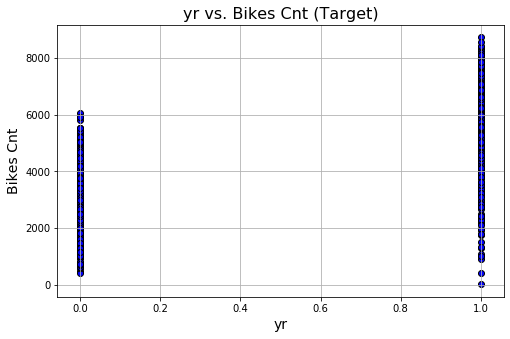

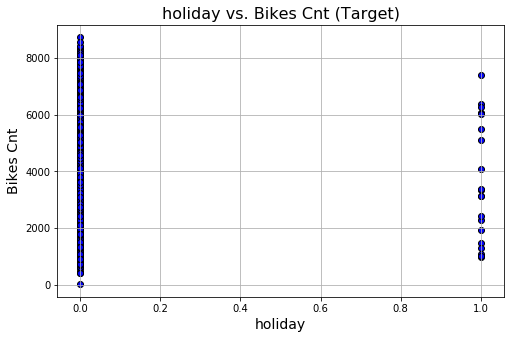

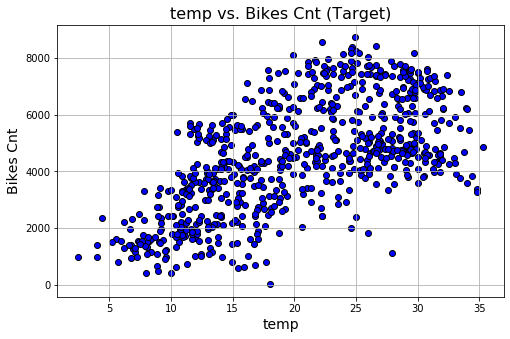

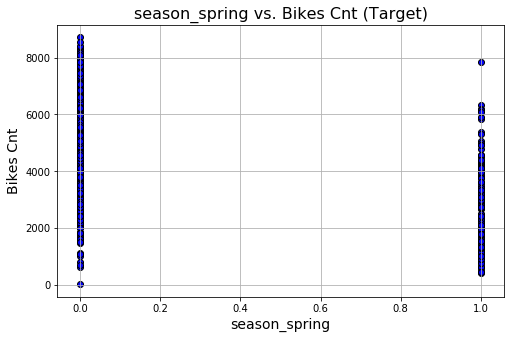

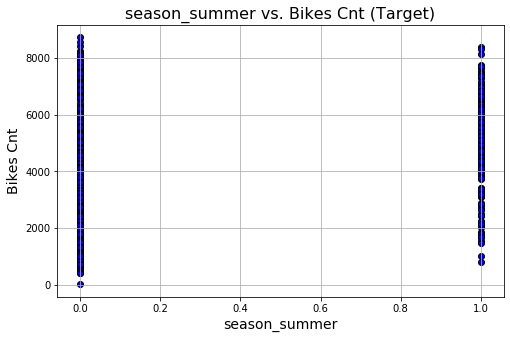

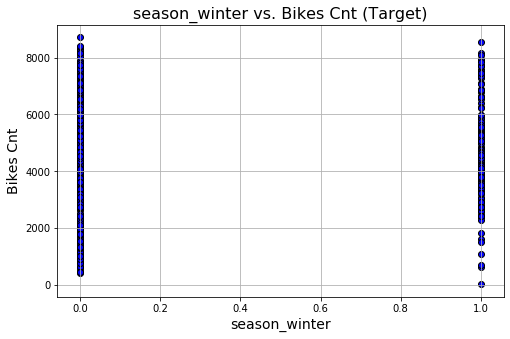

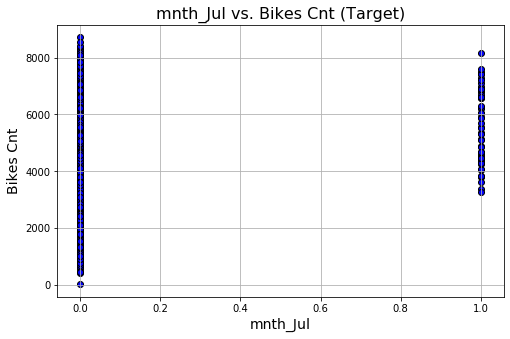

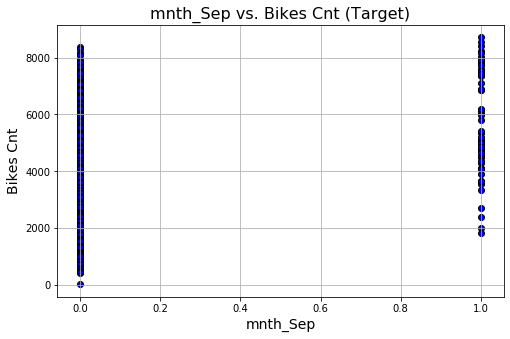

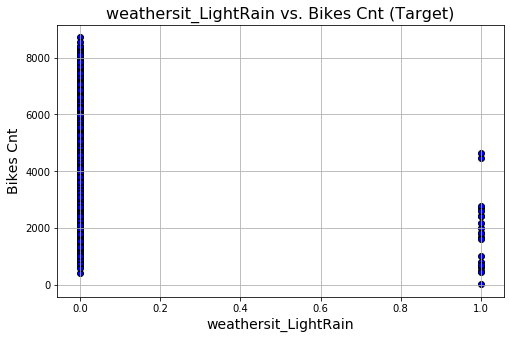

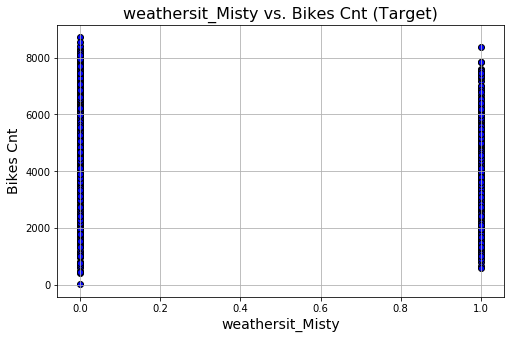

In [65]:
for col in final_variables:
    plt.figure(figsize=(8,5))
    plt.title(f"{col} vs. Bikes Cnt (Target)",fontsize=16)
    plt.scatter(x=bikes[col],y=bikes['cnt'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(col,fontsize=14)
    plt.ylabel('Bikes Cnt',fontsize=14)
    plt.show()


<font color = 'green'>
<b>OBSERVATIONS: </b><br>
    <li> Individual variables have a linear relationship with the target variable</li> 
    <li> There are no clusters for any of the individual variables. </li> 
    <br>
<b>CONCLUSION</b>: Assumption is valid <br>

</font>

##  Normality: The error terms are normally distributed

Plot a density chart with the error terms and check if it is a normal distribution with the mean around 0 <br>
Plot a Q-Q plot for the error terms

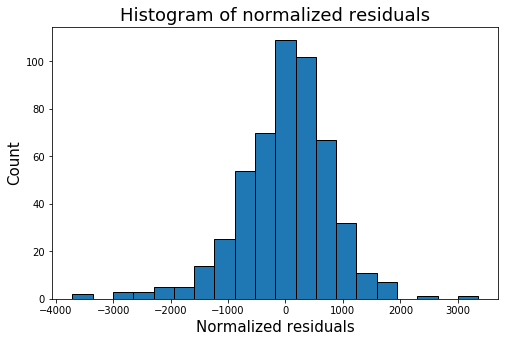

In [66]:
plt.figure(figsize=(8,5))
plt.hist(yerror_train,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

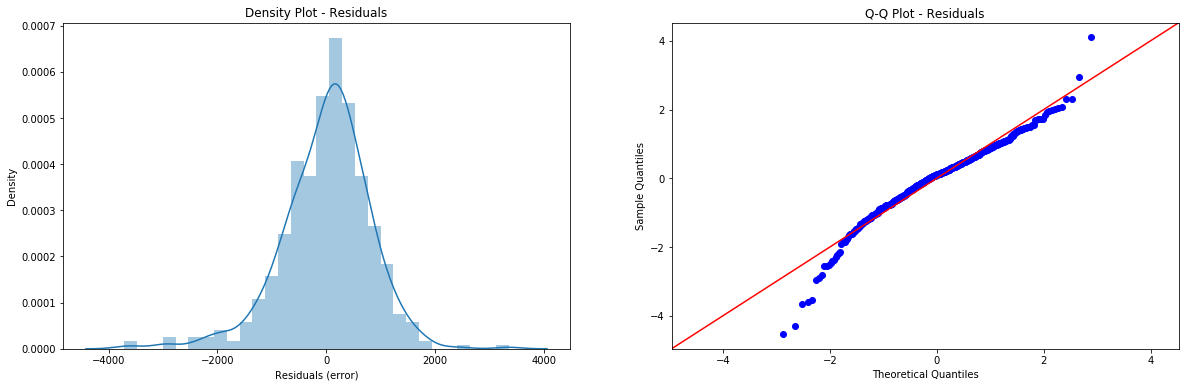

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    
dist = sns.distplot(yerror_train,ax = ax[0])
ax[0].set(xlabel='Residuals (error)',ylabel = 'Density',title = 'Density Plot - Residuals')
qq = sm.qqplot(yerror_train,ax=ax[1],line = '45',fit=True)
ax[1].set(title = 'Q-Q Plot - Residuals')
plt.show()


<font color = 'green'>
<b>OBSERVATIONS: </b><br>
    <li> The error terms are normally distributed </li> 
    <li> The mean of the error terms distribution is around 0 </li> 
    <br>
<b>CONCLUSION</b>: Assumption is valid <br>

</font>

Normality (Shapiro-Wilk) test of the residuals

In [68]:
from scipy.stats import shapiro
_,p=shapiro(yerror_train)
if p<0.01:
    print(f"The residuals seem to come from Gaussian process. p={round(p,5)}")
else:
    print(f"The normality assumption may not hold. p={round(p,5)}")

The residuals seem to come from Gaussian process. p=0.0


## Independence: The error terms are independent of each other

Scatter plot of the error term to each of the predictors

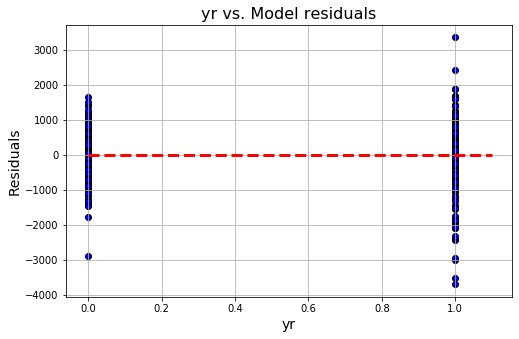

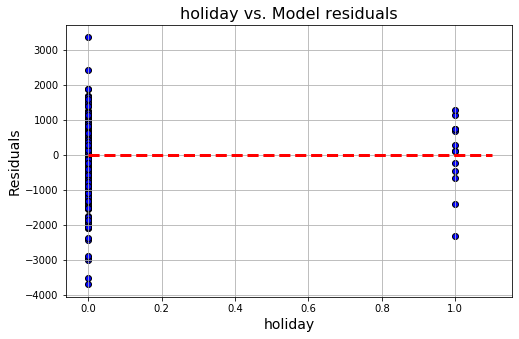

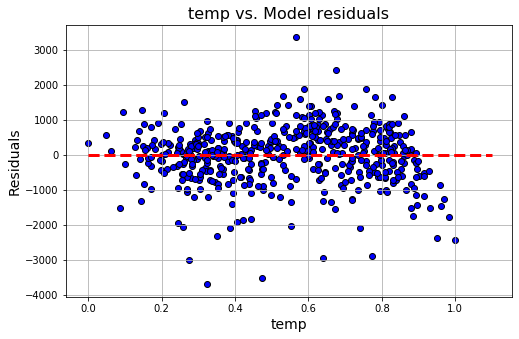

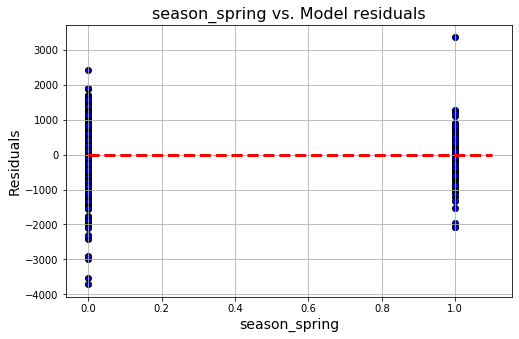

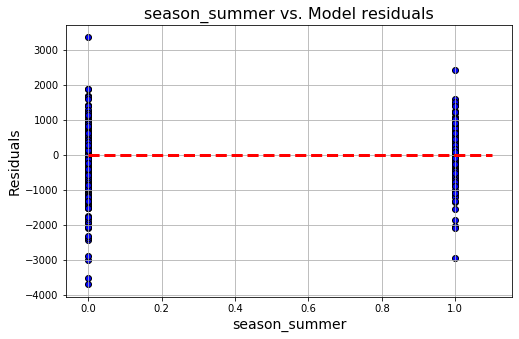

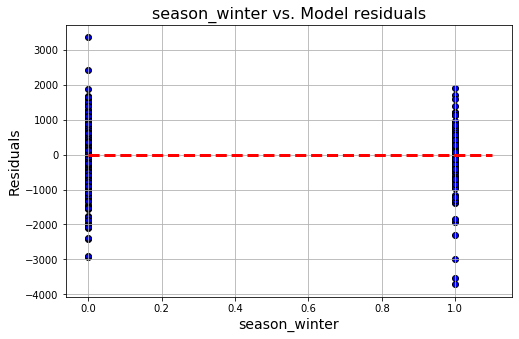

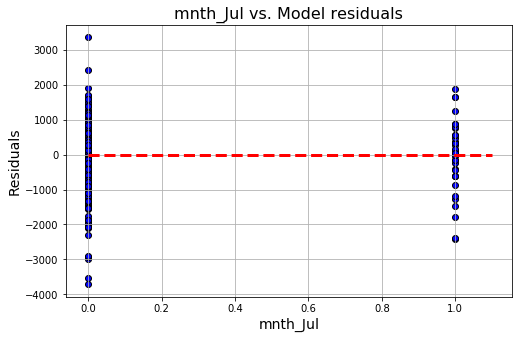

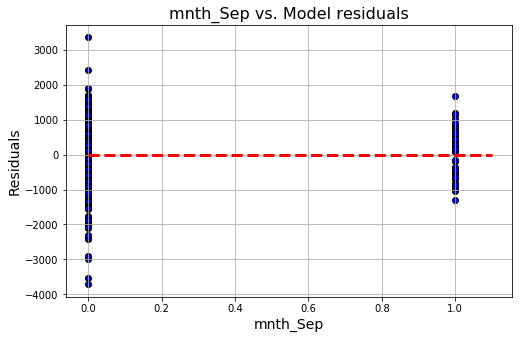

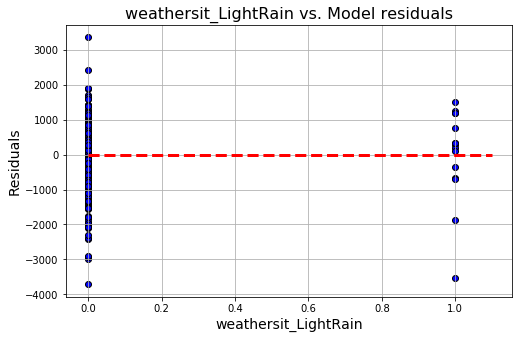

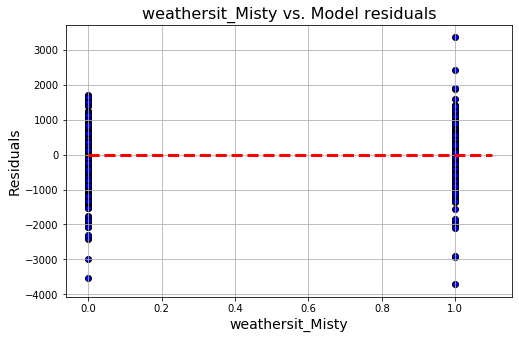

In [69]:
for col in final_variables:
    plt.figure(figsize=(8,5))
    plt.title(f"{col} vs. Model residuals",fontsize=16)
    plt.scatter(x=X_train[col],y=yerror_train,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(X_train[col])
    xmax = max(X_train[col])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(col,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()

<font color = 'green'>
<b>OBSERVATIONS: </b><br>
    <li> The residuals are distributed uniformly randomly around the zero x-axes</li> 
    <li> There are no specific clusters</li> 
    <br>
<b>CONCLUSION</b>: Assumption on independence of the error terms is valid <br>

</font>

## Homoscedasticity: The error terms are within a fixed variance 

Scatter plot of the predicted value against the residuals - variance should be within a fixed range. If the variance keeps increasing as the predicted value increases then it is showing signs of heteroscedasticity.

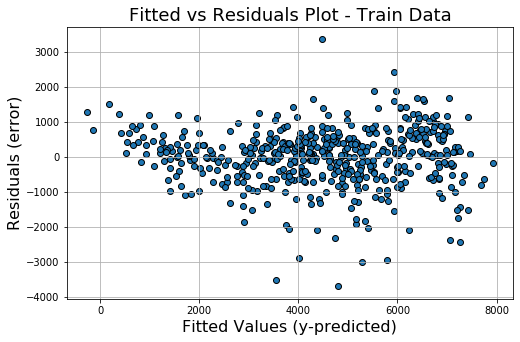

In [70]:
plt.figure(figsize=(8,5))
ax = plt.scatter(ypred_train,yerror_train,edgecolor='k')

plt.xlabel('Fitted Values (y-predicted)', fontsize=16)
plt.ylabel('Residuals (error)', fontsize=16)
plt.title('Fitted vs Residuals Plot - Train Data', fontsize=18)
plt.grid(True)
plt.show()

<font color = 'green'>
<b>OBSERVATIONS: </b><br>
    <li> The variance of the error terms is consistent and within a fixed range </li> 
    <br>
<b>CONCLUSION</b>: Assumption on homoscedasticity is valid <br>

</font>

# Test the model on unseen data

In [71]:
X_test_bk = X_test.copy()
X_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_LightRain,weathersit_Misty
184,0,1,0,29.793347,33.27085,63.7917,5.459106,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,32.082500,36.04875,59.2083,7.625404,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,19.270000,22.85230,81.2917,13.250121,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,31.433347,34.24915,42.4167,13.417286,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,29.315000,32.19710,30.5000,19.583229,0,1,0,...,0,0,0,1,0,0,0,0,0,0


## Treat outliers like it was done in the train data

In [72]:
# Treat high windspeed outliers in test data
X_test.loc[X_test['windspeed'] > q_windspeed_cap,'windspeed']=q_windspeed_cap

# Treat low humidity outliers in test data
X_test.loc[X_test['hum'] < q_hum_floor,'hum'] = q_hum_floor

## Scale the variables in test data

In [73]:
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [74]:
X_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_LightRain,weathersit_Misty
184,0,1,0,0.831783,0.769660,0.493319,0.129351,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,0.901354,0.842587,0.423475,0.236110,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.759993,0.513305,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,0.881625,0.795343,0.167596,0.521544,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.000000,0.825412,0,1,0,...,0,0,0,1,0,0,0,0,0,0


## Predict on test data - statsmodel

In [75]:
# Predict on the test data using statsmodel
X_test_stat = sm.add_constant(X_test[final_variables])
y_pred = lm_stat_model.predict(X_test_stat)

## Predict on test data - sklearn

In [76]:
lm_sklearn = LinearRegression() 
  
# Fit the model on the train dataset using sklearn
lm_sklearn.fit(X_train[final_variables], y_train) 
# Predict the values on the test dataset using sklearn
y_pred_sklearn = lm_sklearn.predict(X_test[final_variables])


# Model Evaluation

## Compare actual vs predicted values in the test data

Text(0, 0.5, 'y_pred')

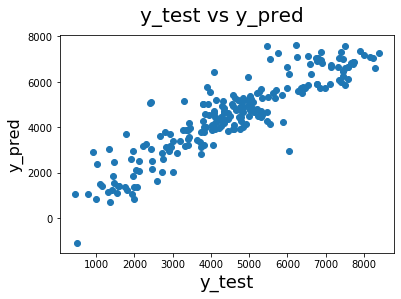

In [77]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

## Compute the R-Squared value

In [78]:
# R2-score for predictions from statsmodel
r2_score(y_test, y_pred)

0.8091540930883703

In [79]:
# R2-score for predictions from sklearn
r2_score(y_test, y_pred_sklearn)

0.8091540930883698

<font color='green'> The R2 values are same from both the statsmodel and sklearn. Both of them can be used for making the predictions. If more statistics analysis is required, it is recommended to use statsmodel. If pipelines are to be used then sklearn is recommended.</font>

# Additional Work - Subjective Questions

## Finding the top 3 features from the final variables

In [80]:
lmtemp = LinearRegression()
lmtemp.fit( X_train[final_variables], y_train)

rfetemp = RFE(lmtemp, 3)    
rfetemp = rfetemp.fit(X_train[final_variables], y_train)

rfe_df1 = pd.DataFrame(zip(X_train[final_variables].columns,rfetemp.support_,rfetemp.ranking_),columns = ['Feature','Selected','Ranking'])
rfe_df1.sort_values(by=['Ranking'])

,Feature,Selected,Ranking
0,yr,True,1
2,temp,True,1
8,weathersit_LightRain,True,1
3,season_spring,False,2
1,holiday,False,3
6,mnth_Jul,False,4
9,weathersit_Misty,False,5
7,mnth_Sep,False,6
5,season_winter,False,7
4,season_summer,False,8


## Scaling

In [81]:
data = bikes[['temp']]

In [82]:
# Summary statistics of temp column before scaling
print("Statistics before scaling")
data.describe()

Statistics before scaling


,temp
count,730.000000
mean,20.319259
std,7.506729
min,2.424346
25%,13.811885
50%,20.465826
75%,26.880615
max,35.328347


In [83]:
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled = pd.DataFrame(scaler.fit_transform(data))
print("After Min-Max scaling")
scaled.describe()

After Min-Max scaling


,0
count,730.000000
mean,0.543852
std,0.228140
min,0.000000
25%,0.346084
50%,0.548307
75%,0.743261
max,1.000000


In [84]:
# define standard scaler
scaler = StandardScaler()
pd.set_option('display.float_format', lambda x: '%.6f' % x)
# transform data
scaled = pd.DataFrame(scaler.fit_transform(data))
print("After Standardized Scaling")
scaled.describe()

After Standardized Scaling


,0
count,730.000000
mean,-0.000000
std,1.000686
min,-2.385484
25%,-0.867466
50%,0.019538
75%,0.874662
max,2.000789


## Q-Q Plot

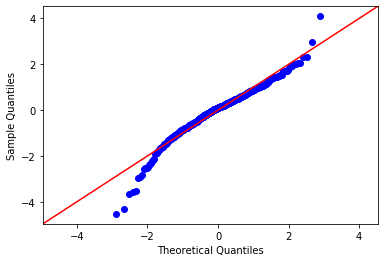

In [85]:
sm.qqplot(yerror_train,line = '45',fit=True)
#sm.qqplot_2samples(X_train, X_test, xlabel=None, ylabel=None, line=None, ax=None)
plt.show()

## VIF of infinity

In [86]:
data = pd.DataFrame({'ht_cm':[150,160,170,180,190]})
data['ht_inch'] = data['ht_cm']*2.54

vif = pd.DataFrame({'Features':data.columns}) 
vif['VIF'] = [round(variance_inflation_factor(data.values, i), 2) for i in range(data.shape[1])]
display(vif)

,Features,VIF
0,ht_cm,inf
1,ht_inch,inf


In [87]:
fit_stats_model(data['ht_cm'],data['ht_inch'])

                            OLS Regression Results                            
Dep. Variable:                ht_inch   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.488e+29
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           3.40e-45
Time:                        10:42:02   Log-Likelihood:                 144.22
No. Observations:                   5   AIC:                            -284.4
Df Residuals:                       3   BIC:                            -285.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.274e-13   5.01e-13     -0.454      0.6

<font color='green'> When the r-squared value is 1, it means that the model can be explained completely by the variables. Here height in inches (ht_inch) can be predicted if the height in cm (ht_cm) is known. </font>